# Rearranger

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
from functools import partial, wraps

In [ ]:
root = tk.Tk()
root.withdraw()

# Open dialog to choose the .txt file
file_type = [('Text File', '*.txt')]
default_dir = 'Input'
file_path = filedialog.askopenfilename(filetypes=file_type, initialdir=default_dir)

# Read the .txt file into a dataframe
raw_df = pd.read_csv(file_path, sep = "\t")

raw_df.head()


In [ ]:
# Remove unnecessary columns
for col in raw_df.columns:
    if "unnamed" in col.lower() or "prob" in col.lower():
        raw_df.drop(col, axis=1, inplace=True)

raw_df

In [ ]:
# Extract the first frame of the video to get a sample image

# Open dialog to choose the .mp4 file
file_type = [('Video File', '*.mp4')]
default_dir = 'Input'
file_path = filedialog.askopenfilename(filetypes=file_type, initialdir=default_dir)
video_P = Path(file_path)

cap = cv2.VideoCapture(file_path)
_, frame = cap.read()
cap.release()

# Export frame as a .png file
image_P = video_P.parent / (video_P.stem + ".png")
cv2.imwrite(str(image_P), frame)


In [ ]:
def get_tanks(im):
    example_tanks = {}

    tank_names = ['Top Left', 'Top Right', 'Bottom Left']

    def tank_selector(im, tank_name):
        while True:
            selected_pixel = cv2.selectROI('Selecting tank at position'+str(tank_name), im)
            
            # print out the coordinates of top left and bottom right pixel of the ROI
            print('Tank at position: ', tank_name)
            print('Top left pixel: x = {}, y = {}'.format(selected_pixel[0], selected_pixel[1]))
            print('Bottom right pixel: x = {}, y = {}'.format(selected_pixel[0] + selected_pixel[2], selected_pixel[1] + selected_pixel[3]))
            print('Middle line: y = {}'.format(selected_pixel[1] + selected_pixel[3] / 2))
            tank_d = math.ceil((selected_pixel[2] + selected_pixel[3]) / 2)
            print('Diameter of the tank : ', tank_d)
            print()
            example_tanks[tank_name] = selected_pixel
            cv2.destroyAllWindows()
            break

    for name in tank_names:
        tank_selector(im, name)

    return example_tanks

In [ ]:
image_P = Path(r"C:\Code\ChungyuanProjects\TowerAssayAnalyzer\Input\Zebrafish Tower\A - Novel Tank Test\01 - Control (1st Batch).png")


In [ ]:

im = cv2.imread(str(image_P))
example_wells = get_tanks(im)

In [ ]:
tanks_col = 5
tanks_row = 2

# tanks number
# 10 9 8 7 6
# 5 4 3 2 1

tanks_dict = {}

TL_num = tanks_col * tanks_row
TR_num = TL_num - tanks_col + 1
BL_num = tanks_col

tanks_dict[TL_num] = example_wells['Top Left']
tanks_dict[TR_num] = example_wells['Top Right']
tanks_dict[BL_num] = example_wells['Bottom Left']
tanks_dict[1] = (tanks_dict[6][0] - (tanks_dict[10][0] - tanks_dict[5][0]), tanks_dict[6][1] - (tanks_dict[10][1] - tanks_dict[5][1]), tanks_dict[6][2]*(tanks_dict[5][2]/tanks_dict[10][2]), tanks_dict[6][3]*(tanks_dict[5][3]/tanks_dict[10][3]))

def fill_row(tanks_dict, start, end, display = True):
    x_sep = (tanks_dict[start][0] - tanks_dict[end][0])/(end - start)
    y_sep = (tanks_dict[start][1] - tanks_dict[end][1])/(end - start)
    w_sep = (tanks_dict[start][2] - tanks_dict[end][2])/(end - start)
    h_sep = (tanks_dict[start][3] - tanks_dict[end][3])/(end - start)

    for i in range(start+1, end):
        tanks_dict[i] = (tanks_dict[end][0] + x_sep*(end-i), tanks_dict[end][1] + y_sep*(end-i), tanks_dict[end][2] + w_sep*(end-i), tanks_dict[end][3] + h_sep*(end-i))
    
    if display:
        for key, value in locals().items():
            print(key + ' = ' + str(value))

    return tanks_dict

for row in range(0, tanks_row):
    tanks_dict = fill_row(tanks_dict, 1 + row*tanks_col, (row+1)*tanks_col)
    # row = 0, fill(tanks_dict, 1 + 0*5,  (0+1)*5)
    # row = 1, fill(tanks_dict, 1 + 1*5,  (1+1)*5)

# tanks_dict = fill_row(tanks_dict, 1, 5)
# tanks_dict = fill_row(tanks_dict, 6, 10)

# round up all the values in tanks_dict to integers
for key in tanks_dict:
    tanks_dict[key] = tuple([int(round(i)) for i in tanks_dict[key]])

tanks_dict


In [ ]:
im = cv2.imread(str(image_P))

# Display predicted tanks
def display_tanks():
    for i in range(1, 11):
        x, y, w, h = tanks_dict[i]
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(im, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Tanks', im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

display_tanks()


In [ ]:
import random
from Libs.misc import display_coords

def coord_generator(box, points = 1000):
    x, y, w, h = box
    coords = []
    for i in range(points):
        x_coord = random.randint(x, x+w)
        y_coord = random.randint(y, y+h)
        coords.append((x_coord, y_coord))
    return coords

def mix_up(input_dict, mix_ratio = 0.3):
    # input_dict has 10 keys 
    # keys are 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    # values are coordinates inside the tanks
    # mix_ratio is the ratio of mixing up the coordinates
    # mix_ratio = 0.3 means 30% of the coordinates will be mixed up

    for i in range(1, len(input_dict)+1):
        if i == 1:
            continue
        else:
            for j in range(1, len(input_dict[i])+1):
                if random.random() < mix_ratio:
                    # swap the coordinates
                    input_dict[i][j-1], input_dict[i-1][j-1] = input_dict[i-1][j-1], input_dict[i][j-1]
    return input_dict
                    
def mix_up_df(input_df, mix_ratio = 0.3):

    for i in range(1, len(input_df.columns)+1, 2):
        if i == 1:
            continue
        else:
            for j in range(1, len(input_df)+1):
                if random.random() < mix_ratio:
                    # swap the coordinates
                    input_df.iloc[j-1, i-1], input_df.iloc[j-1, i-2] = input_df.iloc[j-1, i-2], input_df.iloc[j-1, i-1]

    return input_df

test_dict = {}
for i in range(1, 11):
    test_dict[i] = coord_generator(tanks_dict[i])


columns = []
for i in range (1, 11):
    columns.append('x' + str(i))
    columns.append('y' + str(i))

test_df = pd.DataFrame(columns = columns)
for i in range(1, 11):
    test_df['x' + str(i)] = [x for x, y in test_dict[i]]
    test_df['y' + str(i)] = [y for x, y in test_dict[i]]

test_df

In [ ]:
display_coords(test_df, im)

In [ ]:
mixed_dict = mix_up(test_dict, mix_ratio = 0.3)
mixed_dict

# turn test_dict into dataframe, with 20 columns
# columns = ['x1', 'y1', 'x2', 'y2', ..., 'x10', 'y10']
# rows = 1000

import pandas as pd



mixed_df = pd.DataFrame(columns = columns)
for i in range(1, 11):
    mixed_df['x' + str(i)] = [x for x, y in mixed_dict[i]]
    mixed_df['y' + str(i)] = [y for x, y in mixed_dict[i]]

mixed_df

In [ ]:
display_coords(mixed_df, im)

In [ ]:
cv2.imshow('Tanks', im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def in_box(input_x, input_y, box):
    x, y, w, h = box
    return x <= input_x <= x + w and y <= input_y <= y + h
    
def in_which_tank(x, y):
    for tank_num, tank_box in tanks_dict.items():
        if in_box(x, y, tank_box):
            return tank_num
    return -1

true_df = pd.DataFrame(columns=test_df.columns)
for idx, row in test_df.iterrows():
    for j in range(1, 11):
        x = row['x' + str(j)]
        y = row['y' + str(j)]
        
        tank = in_which_tank(x, y)

        if tank != -1:
            true_df.loc[idx, 'x' + str(j)] = x
            true_df.loc[idx, 'y' + str(j)] = y     

true_df

In [ ]:
display_coords(true_df, im)

In [ ]:
from Libs.misc import load_threshold

threshold_path = 'Bin/thresholds.json'

speed1, speed2 = load_threshold(threshold_path, 'SPEED_1', 'SPEED_2')

speed1, speed2

In [ ]:
from Libs.misc import get_file_path, load_raw_df, clean_df

file_type = [('Text File', '*.txt')]
default_dir = 'Input'
txt_path = get_file_path(file_type, default_dir)

raw_df, tanks_list = load_raw_df(txt_path)

raw_df, _ = clean_df(raw_df, fill = True)

raw_df.head()


In [ ]:
# export to a csv file
raw_df.to_csv('Output/raw_df_withgap.csv', index = False)

In [ ]:
from Libs.misc import display_coords, get_image

im, _ = get_image(source = 'image')
display_coords(raw_df, im, window_name = "Fish 3", tanks_list = tanks_list)


In [ ]:
from Libs.analyzer import NovelTankTest

nvtt1 = NovelTankTest(raw_df)

summary_dict = nvtt1.basiccal()

summary_dict

In [ ]:
int(15.3)

In [ ]:
from Libs.misc import *

final_df, im, tanks_list = draw_prep()

In [ ]:
draw_trajectories(final_df, im, tanks_list, until = 3000)

In [ ]:
from Libs.misc import *

final_df_1, im_1, tanks_list_1 = draw_prep(mode = 'single')

In [ ]:
import time
import cv2

time_range = [200, 250]

time = time_range[0]
while True:
    print('Time frame: ', time)
    draw_trajectories(final_df_1, im_1, tanks_list_1, until = time, wait = 5)
    time += 1
    cv2.waitKey(1)
    # If "spacebar" is pressed, pause the video
    if cv2.waitKey(1) & 0xFF == ord(' '):
        cv2.waitKey(0)
    if time == time_range[1] or cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
for time in range(200, 250):
    draw_trajectories(final_df_1, im_1, tanks_list_1, until = time, wait = 5)
    # if a key is pressed, pause the video
cv2.waitKey(0)
cv2.destroyAllWindows()

# draw_trajectories(final_df_1, im_1, tanks_list_1, until = 230)

In [ ]:
import numpy as np
import pandas as pd

# create an example dataframe with column X Y
# in X there are some Nan values, along with int values
# in Y there are some Nan values, along with int values

df = pd.DataFrame({'X': [1, 2, 3, np.nan, 5, np.nan, 7, 8, 9, 10],
                     'Y': [1, 2, 3, 4, 5, 6, 7, 8, 9, np.nan]})

# find nan in X
nan_coords = np.where(df['X'].isnull())[0]
len(nan_coords)

In [ ]:
my_array = [1, 2, 3, 4, 7, 8, 9, 15, 16, 17]

# turn it into numpy array
my_array = np.array(my_array)

# split my_array into groups of continous numbers, sep = 1
# output = [[1, 2, 3, 4], [7, 8, 9], [15, 16, 17]]

def split_array(my_array, sep = 1):
    # get the difference between each number
    diff = np.diff(my_array)
    # get the index of the difference that is larger than sep
    split_index = np.where(diff > sep)[0]
    # split the array into groups
    split_array = np.split(my_array, split_index + 1)
    return split_array

split_array(my_array)

In [ ]:
import torch

# test cuda
torch.cuda.is_available()


In [ ]:
from Libs.analyzer import *
import pandas as pd

total_csv_path = r'D:\Code\TowerAssayAnalyzer\Output\arranged_C - Mirror Biting Test - full.csv'

total_df = pd.read_csv(total_csv_path)

# get the first tank
first_tank_df = total_df[['X1', 'Y1']].copy()

NTT_Tank1 = NovelTankTest(first_tank_df)

In [ ]:
NTT_Tank1.distance.variables(magic = False)

## Testing the noveltanktest class

In [ ]:
from Libs.misc import load_raw_df, clean_df
from Libs.executor import *

txt_path = "Input/Zebrafish Tower/A - Novel Tank Test/trajectories.txt"
df, _ = load_raw_df(txt_path)
df, _ = clean_df(df, fill = True)

display_dict = NovelTank_Display(df).rows

for key, value in display_dict.items():
    print(key, value)

## Testing the shoalingtest class

In [ ]:
from Libs.misc import load_raw_df, clean_df
from Libs.executor import *

txt_path = "Input/Zebrafish Tower/A - Novel Tank Test/trajectories.txt"
whole_df, _ = load_raw_df(txt_path)
whole_df, _ = clean_df(whole_df, fill=True)
df1, df2, df3 = whole_df.iloc[:, :2], whole_df.iloc[:, 2:4], whole_df.iloc[:, 4:]

whole_df

In [ ]:
from PIL import Image

im = Image.open('Bin/landing_photo.png')

# crop 200px around the image
crop_px = 400
hor_move = 75
ver_move = -35
im = im.crop((crop_px+hor_move, crop_px+ver_move, im.width - crop_px+hor_move, im.height - crop_px+ver_move))

# save
im.save('Bin/landing_photo_cropped.png')

im

# AUTO ANALYZER

In [ ]:
from pathlib import Path
from Libs.batchprocess import MY_DIR


tests = ['Novel Tank', 'Shoaling', 'Mirror Biting', 'Social Interaction', 'Predator Avoidance']
checks = ['novel', 'shoal', 'mirror', 'social', 'predator']
PROJECT_DIR = r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT'
PROJECT_DIR = Path(PROJECT_DIR)

# Get all immediate subdirectories of PROJECT_DIR
subdirectories = [x for x in PROJECT_DIR.glob("*/") if x.is_dir()]
TESTS = {}
for subdirectory in subdirectories:
    if checks[0] in subdirectory.name.lower():
        TESTS[1] = MY_DIR(name=tests[0], dir_path=subdirectory)
    elif checks[1] in subdirectory.name.lower():
        TESTS[2] = MY_DIR(name=tests[1], dir_path=subdirectory, no_gap = True)
    elif checks[2] in subdirectory.name.lower():
        TESTS[3] = MY_DIR(name=tests[2], dir_path=subdirectory)
    elif checks[3] in subdirectory.name.lower():
        TESTS[4] = MY_DIR(name=tests[3], dir_path=subdirectory)
    elif checks[4] in subdirectory.name.lower():
        TESTS[5] = MY_DIR(name=tests[4], dir_path=subdirectory)

# CHECK POINT 1
if len(TESTS) == 5:
    print('TESTS data structure loaded successfully.')


In [ ]:
test_num = 1

In [ ]:
TESTS[test_num].info()

In [ ]:
TESTS[test_num].batch[1].info()

In [ ]:
TESTS[test_num].batch[1].condition['A'].info()

In [ ]:
result_dict_dict = []
for k, v in TESTS[test_num].batch[1].condition['A'].targets.items():
    print(f'Fish group {k:6} : {v.parent.name}/{v.name}')

In [ ]:
fish1_path = TESTS[test_num].batch[1].condition['A'].targets['1']

In [ ]:
from Libs.executor import noveltank_exec

whole = noveltank_exec(fish1_path, segment = -1)


In [ ]:
whole

In [ ]:
seg = {}
for segment in range(int(420/60)):
    print(f"For segment {segment*5} - {segment*5+1} MIN")
    seg[segment] = noveltank_exec(fish1_path, segment = segment)

In [ ]:
seg[1]

In [ ]:
import openpyxl

file_path = r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT\02 - Shoaling Test (Summary).xlsx'
output_path = r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT\merged shoal.xlsx'


def merge_cells(file_path, col_name = 'Shoaling Area', cell_step=3, inplace = True):
    # Load the Excel workbook
    workbook = openpyxl.load_workbook(filename=file_path)

    # Get the active worksheet
    worksheet = workbook.active

    # Find the column index for the "Shoaling Area" header
    shoaling_area_col = None
    for col_idx in range(1, worksheet.max_column+1):
        header = worksheet.cell(row=1, column=col_idx).value
        if header and col_name in header:
            shoaling_area_col = col_idx
            break

    if shoaling_area_col is None:
        print("Column not found.")
    else:
        # Merge every next 3 rows of the Shoaling Area column
        for row_idx in range(2, worksheet.max_row+1, cell_step):
            value = worksheet.cell(row=row_idx, column=shoaling_area_col).value
            print(value)
            if value is not None:
                # Merge the current row with the next 2 rows
                worksheet.merge_cells(start_row=row_idx, start_column=shoaling_area_col, end_row=row_idx+2, end_column=shoaling_area_col)
            
            # align the merged cell, horizontal and vertical center
            worksheet.cell(row=row_idx, column=shoaling_area_col).alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        
    # define output_path
    if inplace == False:
        output_path = file_path[:-5] + '_merged.xlsx'        
    else:
        output_path = file_path    

    # Save the modified workbook
    workbook.save(filename=output_path)

In [ ]:
from pathlib import Path

full_path = r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT\03 - Mirror Biting Test\B - 0.1 ppm (1st Batch)'

condition_path = Path(full_path)
trajectory_format = "trajectories.txt"
trajectories = condition_path.glob(f'**/{trajectory_format}')
list(trajectories)

In [ ]:
from pathlib import Path

def sort_paths_by_parent(paths):
    def sort_key(path):
        name_parts = path.parent.name.split('-')
        if len(name_parts) >= 2:
            try:
                primary_key = int(name_parts[0].strip())
            except ValueError:
                primary_key = int(name_parts[0].strip())
            secondary_key = int(name_parts[1].strip())
        else:
            primary_key = int(name_parts[0].strip())
            secondary_key = 0
        return (primary_key, secondary_key)
    
    return sorted(paths, key=sort_key)

full_path = r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT\03 - Mirror Biting Test\B - 0.1 ppm (1st Batch)'
condition_path = Path(full_path)
trajectory_format = "trajectories.txt"
trajectories = condition_path.glob(f'**/{trajectory_format}')

sorted_trajectories = sort_paths_by_parent(trajectories)

sorted_trajectories

In [ ]:
sorted_trajectories = sorted(list(trajectories), key=lambda p: p.parent)
sorted_trajectories

In [ ]:
from pathlib import Path
import csv

dir_path = Path(r'D:\Code\TowerAssayAnalyzer\Input\OnlyTXT')

path_list = []

for child_dir in dir_path.rglob('*/'):
    if child_dir.is_dir():
        path_list.append(child_dir.relative_to(dir_path))

path_list = [str(path) for path in path_list]

print(path_list)

# write to .csv file
with open('path_list.csv', 'w') as f:
    for path in path_list:
        f.write("%s %s" % (path, '\n'))

In [ ]:
# load from .csv file
with open('path_list.csv', 'r') as f:
    reader = csv.reader(f)
    path_list = list(reader)

path_list = [path[0].strip() for path in path_list]
path_list

In [ ]:

full_path = [dir_path / Path(path) for path in path_list]

full_path

In [ ]:
from pathlib import Path
import csv

dir_path = Path(r'D:\Code\TowerAssayAnalyzer\Input\Test')

structure_csv = 'templates/dir_structure.csv'

with open(structure_csv, 'r') as f:
    reader = csv.reader(f)
    path_list = list(reader)

path_list = [path[0].strip() for path in path_list]
path_list

In [ ]:
path_list[6].format(0.01, 'ppm', '1st')

In [ ]:
from pathlib import Path
import json

dir_path = Path(r'D:\Code\TowerAssayAnalyzer\Input\Test')

structure_json = 'templates/dir_structure.json'

with open(structure_json, 'r') as f:
    path_dict = json.load(f)

for path in path_dict['Parent']:
    print(path)

In [ ]:
for path in path_dict['Child-Control']:
    print(path.format('1st'))

In [ ]:
class PROJECT():

    def __init__(self, name):

        self.name = name
        if self.name == "":
            self.status = False
        else:
            self.status = True

    def give_name(self, name):
        self.name = name
        self.status = True

    def info(self):
        for key, value in self.__dict__.items():
            print(f"{key} : {value}")
        

In [ ]:
project = PROJECT("")
project.status

In [ ]:
project.give_name("test")
project.status

In [ ]:
project.dir = r'D:\Code\TowerAssayAnalyzer\Input\Test'
project.dir

In [ ]:
project.get_info()

In [ ]:
treatment_symbols = [chr(i) for i in range(65, 65+26)]
treatment_symbols

In [ ]:
HISTORY_PATH = "History/projects.json"
ORDINALS = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
CURRENT_PROJECT = "Melamine"
batch_num = 1
TESTLIST = ['Novel Tank Test', 
                    'Shoaling Test', 
                    'Mirror Biting Test',
                    'Social Interaction Test',
                    'Predator Avoidance Test']

# turn batch_num into ordinal
batch = ORDINALS[int(batch_num)-1]

# change number 2 into B, using mathematically

with open(HISTORY_PATH, "r") as file:
    projects_data = json.load(file)

treatments = projects_data[CURRENT_PROJECT]["TREATMENTS"]

all_paths = {}

all_paths['Parent'] = []
for i, test in enumerate(TESTLIST):
    temp = f"0{i+1} - {test}"
    all_paths['Parent'].append(temp)

tail = f"A - Control ({batch} Batch)"
all_paths['Child-A'] = [f"{parent}\\{tail}" for parent in all_paths['Parent']]

for k, v in treatments.items():
    if k == "Treatment A":
        continue
    char = k.split()[1]
    tail = f"{char} - {v[1]} {v[2]} ({batch} Batch)"
    all_paths[f"Child-{char}"] = [f"{parent}\\{tail}" for parent in all_paths['Parent']]

all_paths

In [ ]:
for v in all_paths['Child-A']:
    print(v)

In [ ]:
HISTORY_PATH = "History/projects.json"
ORDINALS = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
CURRENT_PROJECT = "Melamine"
batch_num = 1
TESTLIST = ['Novel Tank Test', 
                    'Shoaling Test', 
                    'Mirror Biting Test',
                    'Social Interaction Test',
                    'Predator Avoidance Test']

# turn batch_num into ordinal
batch = ORDINALS[int(batch_num)-1]

# change number 2 into B, using mathematically

with open(HISTORY_PATH, "r") as file:
    projects_data = json.load(file)

treatments = projects_data[CURRENT_PROJECT]["TREATMENTS"]

all_paths = {}

all_paths['Parent'] = []
for i, test in enumerate(TESTLIST):
    temp = f"0{i+1} - {test}"
    all_paths['Parent'].append(temp)


In [ ]:

normal_parents = []
group_parents = []
for path in all_paths['Parent']:
    if "Shoaling" in path:
        group_parents.append(path)
    else:
        normal_parents.append(path)

normal_parents, group_parents

In [ ]:

for k, v in treatments.items():
    char = k.split()[1]
    print(char)
    if char == "A":
        tail = f"A - Control ({batch} Batch)"
    else:
        tail = f"{char} - {v[1]} {v[2]} ({batch} Batch)"

    fish_num = int(v[3])
    all_paths[f"Child-{char}"] = [f"{parent}\\{tail}" for parent in all_paths['Parent']]
    for i in range(1, fish_num+1):
        all_paths[f"Child-{char}"].extend([f"{parent}\\{tail}\\{i}" for parent in normal_parents])
    fish_group = fish_num // 3
    for i in range(1, fish_group+1):
        all_paths[f"Child-{char}"].extend([f"{parent}\\{tail}\\{i}" for parent in group_parents])


all_paths

In [ ]:
example_dict = {
    (1, 2) : 2,
    (4, 10) : 7
}

list(example_dict.keys())[0][0]

In [15]:
from Libs.analyzer import NovelTankTest
from Libs.executor import NovelTank_Display
from Libs.misc import get_file_path, load_raw_df, clean_df
import os

# file_type = [('Text File', '*.txt')]
# default_dir = 'Input'
# txt_path = get_file_path(file_type, default_dir)
txt_path = r'D:/TestSave/MelamineTest/01 - Novel Tank Test/A - Control (1st Batch)/1/trajectories.txt'
raw_df, tanks_list = load_raw_df(txt_path)
raw_df, _ = clean_df(raw_df, fill = True)

seg_num = len(raw_df) // 3000


In [17]:
for num in range(1, 10):
    fish_num = str(num)
    txt_path = os.path.join(r"D:/TestSave/MelamineTest/01 - Novel Tank Test/A - Control (1st Batch)", fish_num, "trajectories.txt")
    raw_df, tanks_list = load_raw_df(txt_path)
    raw_df, _ = clean_df(raw_df, fill = True)
    test = NovelTankTest(input_df = raw_df, project_hyp = {}, fish_num = fish_num, segment = 0)
    display = NovelTank_Display(input_df = raw_df, project_hyp = {}, fish_num = fish_num, segment = 0)
    print("Fish Number: ", fish_num)
    print(test.others)
    print(display.rows)



Fish Number:  1
{'distance in top': 43.432799393071996, 'top/bottom ratio': 0.13851992409867173, 'distance top/bottom ratio': 0.15839612942291195, 'latency in frames': 284, 'latency in seconds': 5.68, 'entry number': 9, 'average entry': 0.8111111111111111}
{0: ['Total Distance', 317.6364655515296, 'cm'], 1: ['Average Speed', 5.29570632796814, 'cm/s'], 2: ['Freezing Percentage', 4.668222740913638, '%'], 3: ['Swimming Percentage', 87.29576525508503, '%'], 4: ['Rapid Movement Percentage', 8.036012004001334, '%'], 5: ['Average distance to center', 7.0136, 'cm'], 6: ['Time in top', 12.166666666666668, '%'], 7: ['Time in bottom', 87.83333333333333, '%'], 8: ['Time spent in top/bottom ratio', 0.13851992409867173, ''], 9: ['Distance traveled in top', 43.432799393071996, 'cm'], 10: ['Distance traveled top/bottom ratio', 0.15839612942291195, ''], 11: ['Latency in frames', 284, 'frames'], 12: ['Latency in seconds', 5.68, 'seconds'], 13: ['Number of entries', 9, ''], 14: ['Average entry', 0.811111

In [ ]:
1896/86=22.069767441860465

1004/42=23.80952380952381
223/11=20.272727272727273




In [7]:
#make empty set
# add value 197.7 to set

empty_set = set()
empty_set.add(197.7)

empty_set

{197.7}

In [8]:
# get value from set
value = empty_set.pop()
value

197.7

In [7]:
value = {
    "A" : 1,
    "B" : 2,
    "C" : 3
}

desired_key_num = 5

# if number of keys is less than desired key number, add new key with default value = 0 until number of keys is equal to desired key number
# if number of keys is greater than desired key number, remove last key until number of keys is equal to desired key number
# if number of keys is equal to desired key number, do nothing

if len(value) < desired_key_num:
    # check type of value.values(), if it is a list, new_value = [0,0], else new_value = 0
    if type(list(value.values())[0]) == list:
        default_value = [0,0]
    else:
        default_value = 0
    while len(value) < desired_key_num:
        value[chr(len(value)+65)] = default_value
elif len(value) > desired_key_num:
    while len(value) > desired_key_num:
        value.popitem()
else:
    pass

value

{'A': 1, 'B': 2, 'C': 3, 'D': 0, 'E': 0}

{'A': 1, 'B': 2}

In [8]:
int("60.0")

ValueError: invalid literal for int() with base 10: '60.0'

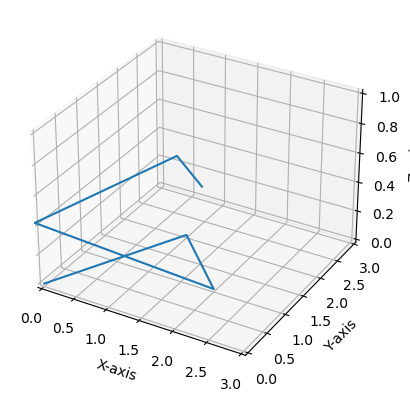

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_fish_movement(set1, set2, theta, tank_x_size=None, tank_y_size=None, tank_z_size=None):
    x1, y1 = set1
    x_mirrored, y_mirrored = set2
    
    # Calculate actual z and x coordinates from the mirrored coordinates
    z2 = y_mirrored * np.sin(np.radians(theta)) / (2 * np.sin(np.radians(90 - theta)))
    x2 = x_mirrored - z2 * np.tan(np.radians(theta))
    
    # Combine both sets of coordinates
    x = np.concatenate((x1, x2))
    y = np.concatenate((y1, y1))  # Assuming y-axis values are the same for both sets
    z = np.concatenate((np.zeros_like(z2), z2))
    
    # Calculate tank size if not provided
    if tank_x_size is None:
        tank_x_size = max(x)*1.5
    if tank_y_size is None:
        tank_y_size = max(y)*1.5
    if tank_z_size is None:
        tank_z_size = max(z)*1.5
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z)
    
    # Set the axis limits
    ax.set_xlim(0, tank_x_size)
    ax.set_ylim(0, tank_y_size)
    ax.set_zlim(0, tank_z_size)
    
    # Set axis labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    # Show the plot
    plt.show()

# Example usage
set1 = (np.array([0, 1, 2]), np.array([0, 2, 1]))
set2 = (np.array([0, 1, 2]), np.array([3, 4, 5]))
theta = 15

plot_fish_movement(set1, set2, theta)


In [1]:
from Libs.misc import hyploader

hyp_path = "Bin\hyp_mirror.json"

data = hyploader(hyp_path)

In [2]:
data

{'FPS': 50,
 'DURATION': 300,
 'CONVERSION RATE': 12.1519,
 'ZONE WIDTH': 4,
 'MIRROR': {'1': [407, 0],
  '2': [402, 0],
  '3': [397, 0],
  '4': [397, 0],
  '5': [403, 0],
  '6': [341, 1],
  '7': [338, 1],
  '8': [337, 1],
  '9': [333, 1],
  '10': [331, 1]},
 'MIRROR ZONE': {'1': [455.6076, 0],
  '2': [450.6076, 0],
  '3': [445.6076, 0],
  '4': [445.6076, 0],
  '5': [451.6076, 0],
  '6': [292.3924, 1],
  '7': [289.3924, 1],
  '8': [288.3924, 1],
  '9': [284.3924, 1],
  '10': [282.3924, 1]}}

In [8]:
from pathlib import Path

ori_dir = Path("Input/Melamine")

# get the full path of ori_dir

ori_full = ori_dir.resolve()
ori_full

WindowsPath('D:/Code/TowerAssayAnalyzer/Input/Melamine')

In [17]:
char_list = [chr(i) for i in range(65, 91)]
# Find all .txt files within the project directory
txt_files = ori_dir.glob("**/*.txt")

# change all paths in txt_files to fullpath
txt_paths = [txt_file.resolve() for txt_file in txt_files]



def check_grandparent_format(txt_path, batch_num):
    # check if the grandparent folder of txt_path is in the format of "A - Control (1st Batch)"
    # if yes, return True, else return False

    grandparent = txt_path.parent.parent.name
    sign = grandparent.split("-")[0].strip()
    treatment = grandparent.split("-")[1].strip()
    batch_ord = treatment.split("(")[1].split(" ")[0].strip()
    # change ordinal to number, 1st -> 1
    if batch_num != int(batch_ord[:-2]):
        return None
    if sign not in char_list:
        # change it from number to letter, 1 -> A
        sign = chr(int(sign) + 64)
    
    return f"{sign} - {treatment}"

def check_test(txt_path):
    # check if any word in name_dict.keys() is in str(txt_path).lower()
    # if yes then construct a name based on the found name
    name_dict = {
        "novel tank" : "01 - Novel Tank Test",
        "shoaling" : "02 - Shoaling Test",
        "mirror" : "03 - Mirror Test",
        "social" : "04 - Social Interaction Test",
        "predator" : "05 - Predator Test"
    }

    for key in name_dict.keys():
        if key in str(txt_path).lower():
            return name_dict[key]

In [21]:
def get_project_path(txt_path, project_dir, batch_num):
    gparents = check_grandparent_format(txt_path, batch_num)
    if gparents == None:
        return None
    # if the txt_path contain "novel tank"
    ancestors = Path(check_test(txt_path)) / Path(gparents)
    # get the parent and name of txt_path
    parent = txt_path.parent.name
    file = txt_path.name
    return project_dir / ancestors / parent / file

project_dir = Path(r"D:\TestSave\M2")

get_project_path(txt_paths[0], project_dir)

WindowsPath('D:/TestSave/M2/01 - Novel Tank Test/A - Control (1st Batch)/1/trajectories.txt')

In [1]:
8//10

0

In [4]:

def find_end_row(last_row, cell_step = 10):
    return (((last_row-2)//cell_step)+1)*cell_step

find_end_row(12)

20

In [3]:
30 % 11 == 8

True

In [5]:
a // 30 == 1 and a % 30 == 0
a = 30

1

In [ ]:
from Libs.misc import count_batch

tests = ['Novel Tank', 'Shoaling', 'Mirror Biting', 'Social Interaction', 'Predator Avoidance']
keywords = [x.split(' ')[0].lower() for x in tests]
EXCEL_NAMES = [f"0{i+1} - {tests[i]} Test (Summary).xlsx" for i in range(len(tests))]

PROJECT_DIR = Path(r"D:\TestSave\M2")

test_num = 0
excel_name = EXCEL_NAMES[test_num]
excel_path = PROJECT_DIR / excel_name



In [1]:
from pathlib import Path


file_path = Path("ABC/abc.exe")

file_path.suffix

'.exe'

In [5]:
import openpyxl
import os

path = r"D:\TestSave\Mel\01 - Novel Tank Test (Summary).xlsx"

wb = openpyxl.load_workbook(path)

ws = wb.active

ws.max_row


31

In [6]:
300.1 - 300 == 0.0

False

In [6]:
from num2words import num2words

num2words(10, to='ordinal_num')

'10th'

In [12]:
from word2number import w2n

w2n.ordinal_to_num("1st")

AttributeError: module 'word2number.w2n' has no attribute 'ordinal_to_num'

In [ ]:
test_dir = Path(r"D:\TestSave\DifNum\01 - Novel Tank Test")

ORDINALS = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
treatment_num = "A"
batch_num = 1
batch_ordinal = ORDINALS[batch_num - 1]

treatment_dir = test_dir.glob(f"*{treatment_num}*({batch_ordinal} Batch)")
